In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from scipy.stats import normaltest

# в модуле statsmodels реализованы методы статистического моделирования для временных рядов

from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame

In [2]:
# настройки отображения графиков
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 5)
plt.rcParams['font.family'] = 'sans-serif'

In [3]:
df = pd.read_csv(
    '/opt/kate_repo/real_data_analysis/wargaming_task/Wargaming_task_one.csv')
df.head()

,dt,"Revenue, BYN"
0,02/02/2017,7402991
1,02/03/2017,7165318
2,02/04/2017,7034603
3,02/05/2017,8901133
4,02/06/2017,9238895


In [4]:
df.dtypes

dt              object
Revenue, BYN     int64
dtype: object

In [5]:
# Корректировка формата даты
df['dt'] = pd.to_datetime(df['dt'])

In [6]:
# Переименование столбцов
df.rename(columns=lambda x: x.replace('dt', 'date'), inplace=True)
df.rename(columns=lambda x: x.replace('Revenue, BYN', 'revenue'), inplace=True)

In [7]:
# Добавление данных о днях недели
df['day_of_week'] = df['date'].apply(lambda time: time.strftime("%A"))

In [8]:
df

,date,revenue,day_of_week
0,2017-02-02,7402991,Thursday
1,2017-02-03,7165318,Friday
2,2017-02-04,7034603,Saturday
3,2017-02-05,8901133,Sunday
4,2017-02-06,9238895,Monday
...,...,...,...
265,2017-10-25,6257772,Wednesday
266,2017-10-26,6827791,Thursday
267,2017-10-27,7789467,Friday
268,2017-10-28,6911239,Saturday


<AxesSubplot:>

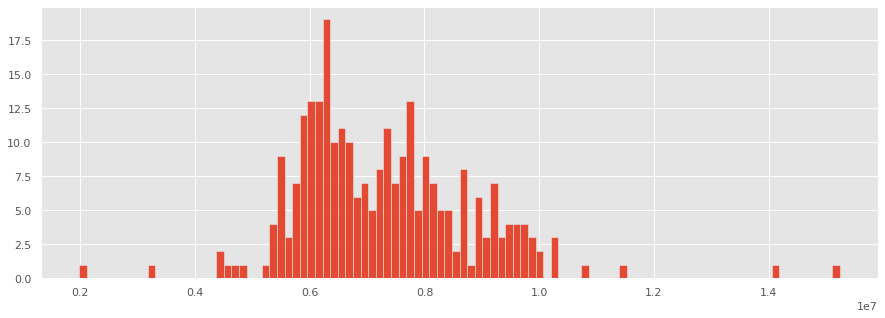

In [9]:
df.revenue.hist(bins=100)

/home/kate/.local/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='revenue'>

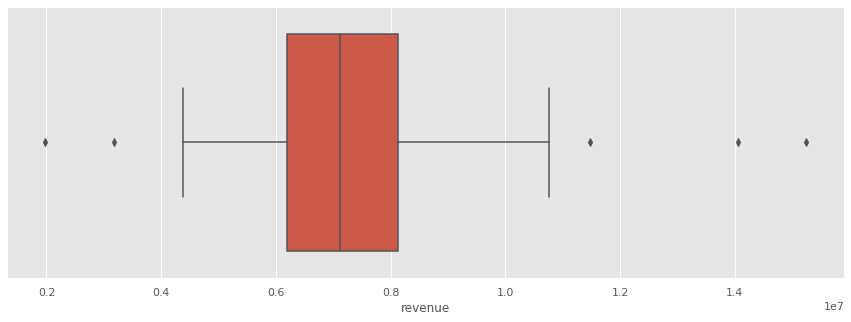

In [10]:
# Распределение параметра revenue

sns.boxplot(df['revenue'], orient='h')

In [11]:
df.revenue.describe()

count    2.700000e+02
mean     7.281373e+06
std      1.530439e+06
min      1.978644e+06
25%      6.200241e+06
50%      7.112128e+06
75%      8.135015e+06
max      1.524611e+07
Name: revenue, dtype: float64

In [12]:
# Коэффициент вариации (степень изменчивости по отношению к среднему показателю выборки)
print('V = %f' % (df.revenue.std() / df.revenue.mean()))

V = 0.210186


In [13]:
# Оценка распределения дохода
data = df.revenue

stat, p = normaltest(data)
print('Statistics=%.3f, p=%.3f' % (stat, p))

alpha = 0.05
if p > alpha:
    print('Нормальное распределение дохода')
else:
    print('Распределение дохода не является нормальным')

Statistics=56.931, p=0.000
Распределение дохода не является нормальным


In [14]:
# Динамика дохода за весь период

import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

trace1 = go.Scatter(x=df.date,
                    y=df.revenue,
                    name="Динамика дохода",
                    line=dict(color='blue'),
                    opacity=0.4)

layout = dict(title='Динамика дохода', )

fig = dict(data=[trace1], layout=layout)
iplot(fig)

Визуально временной ряд выглядит как стационарный - отсутствует четкая тенденция и сезонный эффект
Для статистического определения насколько сильно временной ряд определеяется трендом будет использован Augmented Dickey–Fuller test, где нулевая гипотеза - временной ряд является нестационарным и имеет временную структуру.

In [15]:
# насколько сильно временной ряд определяется трендом
from statsmodels.tsa.stattools import adfuller

X = df.revenue.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.462995
p-value: 0.000229
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


Полученное статистическое значение -4.462995 меньше, чем -3.456 при 1%, что позволяет отклонить нулевую гипотезу с уровнем значимости менее 1% (низкой вероятностью статистической случайности).
Временной ряд является стационарным

Для стационарного временного ряда будет использована Модель авторегрессии — скользящего среднего (ARMA).

Text(0.5, 1.0, 'Динамика по дням недели')

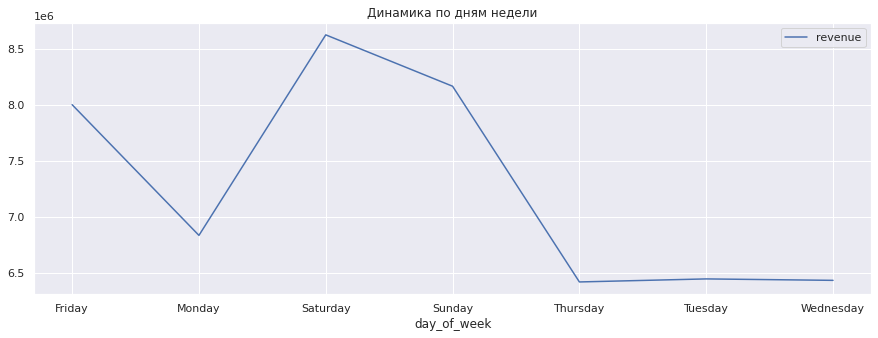

In [16]:
# График изменения дохода по дням недели
sns.set()  # стили библиотеки Seaborn
df.pivot_table('revenue', index='day_of_week', aggfunc='mean').plot()
plt.title('Динамика по дням недели')

# изменить расположение дней недели (не по алфавиту)

In [17]:
df.date.max()

Timestamp('2017-10-29 00:00:00')

In [18]:
# Фильтр по периоду скидки с 13.10.17 по 16.10.17
sale_date = df[(df['date'] >= '2017-10-13') & (df['date'] <= '2017-10-16')]

In [19]:
# Фильтр с 27.09.17 по 16.10.17
renewal_date = df[(df['date'] >= '2017-09-27') & (df['date'] <= '2017-10-16')]

In [20]:
# Фильтр до 13.10.2017
before_sale = df[(df['date'] < '2017-10-13')]

<AxesSubplot:label='352831d3-2b03-4f6a-a984-d3a03dac873d', xlabel='date', ylabel='day_of_week'>

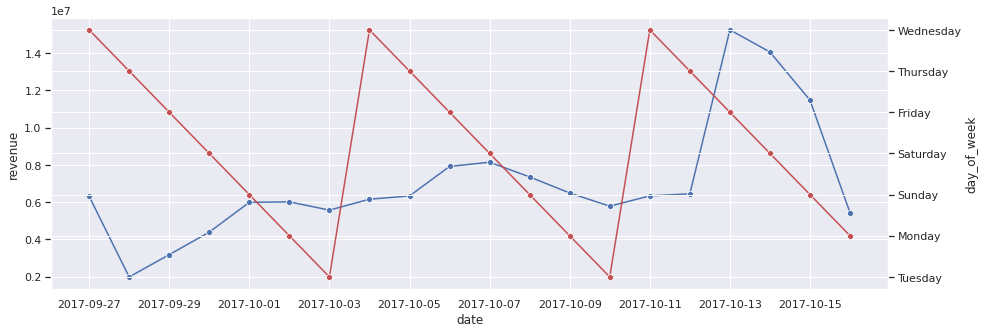

In [21]:
# Динамика дохода после обновления
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
sns.lineplot(x=renewal_date.date,
             y=renewal_date.revenue,
             color='b',
             marker='o',
             ax=ax1)

# Дни недели
sns.lineplot(x=renewal_date.date,
             y=renewal_date.day_of_week,
             color='r',
             marker='o',
             ax=ax2, sort=False)

# Можно сделать гистограмму для дней недели и закрашивать только субботу и воскресенье

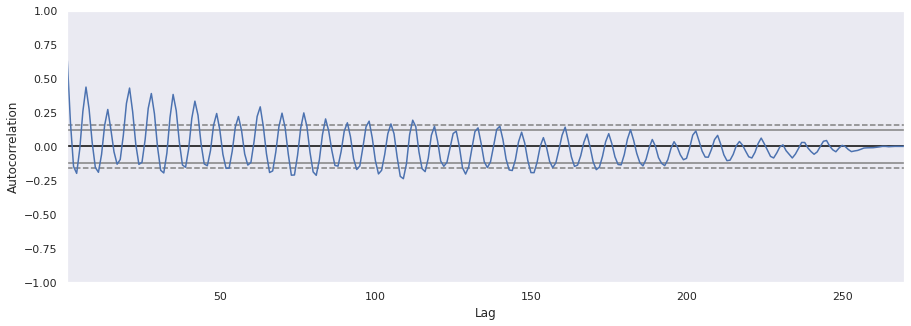

In [22]:
# автокорреляция
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot

autocorrelation_plot(df.revenue)
pyplot.show()

### Модель ARMA

Test MSE: 1578859235782.565


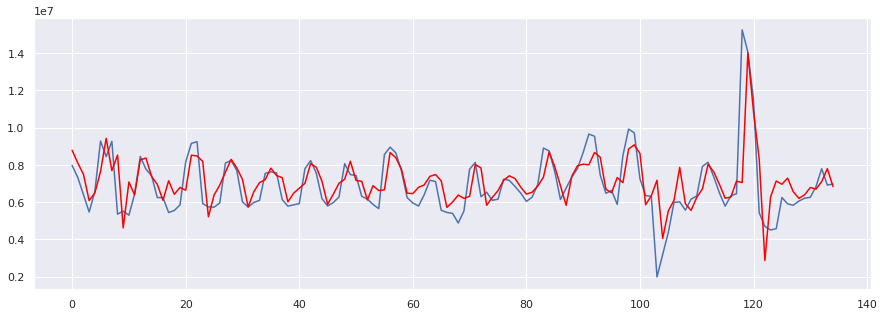

In [23]:
X = df.revenue.values
size = int(len(X) * 0.5)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5, 0, 0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
#     print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

In [24]:
# Согласно результатам модели, предсказанная выручка за период предоставления скидки составила бы:

predicted_sum = (7114530.432153 + 13907526.986257 + 11326865.623015 +
                 8835329.534139)
predicted_sum

# Можно найти прогнозные значения через фактические за выбранный период

41184252.575564

In [25]:
# Фактическая выручка за период предоставления скидки составила:
fact_sum = sale_date.revenue.sum()
fact_sum

46202266

In [26]:
# Отличие факта от прогноза в %
((fact_sum / predicted_sum) * 100) - 100

12.18430130601267